#### Generate SQL without HANA execution

`disable_hana_execution` has been implemented for all PAL functions that are inherited from pal_base.

In [1]:
import pandas as pd
from hana_ml.algorithms.pal.pipeline import Pipeline 
from hana_ml.algorithms.pal.decomposition import PCA
from hana_ml.algorithms.pal.trees import HybridGradientBoostingClassifier

In [2]:
from hana_ml import dataframe
from hana_ml.algorithms.pal.utility import DataSets, Settings
import plotting_utils

url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)


In [3]:
full_set, diabetes_train, diabetes_test, _ = DataSets.load_diabetes_data(connection_context)

my_pipeline = Pipeline([
                    ('PCA', PCA(scaling=True, scores=True)),
                    ('HGBT_Classifier', HybridGradientBoostingClassifier(
                                            n_estimators=4, split_threshold=0,
                                            learning_rate=0.5, fold_num=5,
                                            max_depth=6))])
my_pipeline.disable_hana_execution()
my_pipeline.fit(data=diabetes_train, key="ID", label="CLASS")

print(my_pipeline.get_fit_execute_statement())

Table PIMA_INDIANS_DIABETES_TBL exists.
DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'HAS_ID';
int_value[1] := 1;
double_value[1] := NULL;
string_value[1] := NULL;
param_name[2] := N'PIPELINE';
int_value[2] := NULL;
double_value[2] := NULL;
string_value[2] := N'{"HGBT_Classifier": {"args": {"ITER_NUM": 4, "MAX_DEPTH": 6, "GAMMA": 0.0, "FOLD_NUM": 5, "ETA": 0.5}, "inputs": {"data": {"CATPCA": {"args": {"SCALING": 1, "SCORES": 1}, "inputs": {"data": "ROWDATA"}}}}}}';
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "ID", "PREGNANCIES", "GLUCOSE", "SKINTHICKNESS", "INSULIN", "BMI", "AGE", "CLASS" FROM (SELECT a.* FROM #PAL_PARTITION_DATA_TBL_DBB29C7D_954A_11ED_9384_F47B099F40D8 a inner join #PAL_PARTITION_RESULT_TBL_DBB29C7D_954A_11ED_9384_F47B099F40D8 b        on a."ID" = b."ID" where b."PARTITION_TYPE" = 1) AS "DT_5";
CA

#### Added nullif function

`nullif` function will change the target value to NULL. It also provide dict input for column subset NULL replacement.

In [4]:

dataset_null = dataframe.create_dataframe_from_pandas(connection_context=connection_context,
                                                      pandas_df=pd.DataFrame({"ID": [1,2,5],
                                                                              "ID2": [1,None,5],
                                                                              "V3": [2,3,4],
                                                                              "V4": [3,3,3],
                                                                              "V5": ['a', None, 'b']}),
                                                      table_name="#tt_null",
                                                      force=True)

dataset_null.nullif(3).collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


ID  ID2   V3    V4    V5
0   1  1.0  2.0  None     a
1   2  NaN  NaN  None  None
2   5  5.0  4.0  None     b

In [5]:
dataset_null.nullif({'V4': 3, 'ID': 1}).collect()

ID  ID2  V3    V4    V5
0  NaN  1.0   2  None     a
1  2.0  NaN   3  None  None
2  5.0  5.0   4  None     b

#### New EDA - plot_change_points, plot_psd

In [6]:
data1 = [369,657,544,623,615,773,449,531,717,778,907,517,402,691,623,583,479,529,540,289,51,89,57,36,10,31,7,38,10,11,7,8,3,7,3,1,5,-1,3,9]

dt_ml = dataframe.create_dataframe_from_pandas(connection_context,
                                               pd.DataFrame({'TIME_STAMP':[i for i in range(len(data1))],'SERIES':data1}),
                                               table_name="#PAL_MOCKING_BCPD_DATA_1_TBL")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


<AxesSubplot:title={'center':'Change Points'}, xlabel='TIME_STAMP', ylabel='SERIES'>

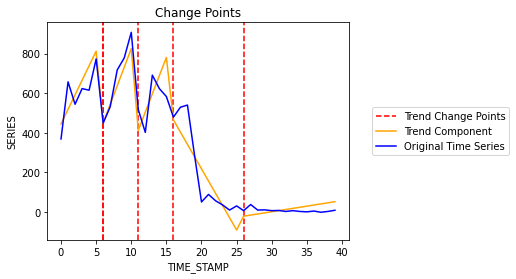

In [7]:
from hana_ml.visualizers.eda import plot_change_points
from hana_ml.algorithms.pal.tsa.changepoint import BCPD

bcpd = BCPD(max_tcp=5, max_scp=0, random_seed=1, max_iter=1000)
plot_change_points(data=dt_ml, col='SERIES', key= 'TIME_STAMP', cp_object=bcpd)

In [8]:
import numpy as np
df_psd = dataframe.create_dataframe_from_pandas(connection_context,
                                                pd.DataFrame({'ID':np.array([i for i in range(8)]), 'Y':np.array([-2.0, 8.0, 6.9, 4.0, 1.0, 0.0, 3.0,5.0])}),
                                                table_name='#PAL_PERIODOGRAM_PAL', force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


<AxesSubplot:title={'center':'Periodogram'}>

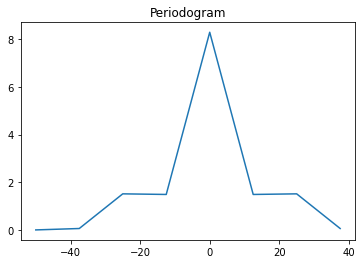

In [9]:
# psd
from hana_ml.visualizers.eda import plot_psd
plot_psd(data=df_psd,
         col="Y", 
         key="ID",
         sampling_rate=100.0,
         window="hamming",
         freq_range="two_sides",
         spectrum_type="spectrum")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


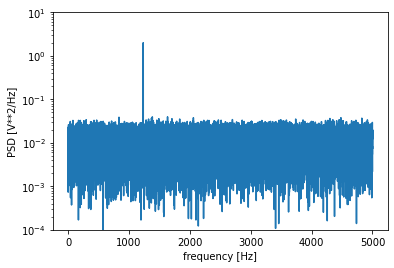

In [10]:
# example 2
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x2 = amp*np.sin(2*np.pi*freq*time)
x2 += rng.normal(scale=np.sqrt(noise_power), size=time.shape)
f, Pxx_spec = signal.periodogram(x2, fs, window='hann', scaling='spectrum')
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.ylim([1e-4, 10])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.61s/it]


<AxesSubplot:title={'center':'Periodogram'}>

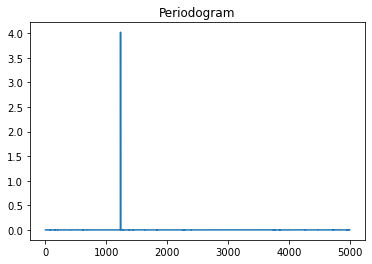

In [11]:
df_perio =dataframe.create_dataframe_from_pandas(connection_context,
                                                 pd.DataFrame({'ID':np.array([i for i in range(100000)]), 'Y':x2}),
                                                 table_name='#PAL_PERIODOGRAM', force=True)
plot_psd(data=df_perio,
         col="Y", 
         key="ID",
         sampling_rate=10e3,
         spectrum_type='spectrum',
         window='hann')

#### periodogram

In [12]:
data = [['2016-07-01 00:00:00',  5.827,  2.009,  1.599,  0.462,  4.203,  1.340,  30.531000],
        ['2016-07-01 01:00:00',  5.693,  2.076,  1.492,  0.426,  4.142,  1.371,  27.787001],
        ['2016-07-01 02:00:00',  5.157,  1.741,  1.279,  0.355,  3.777,  1.218,  27.787001],
        ['2016-07-01 03:00:00',  5.090,  1.942,  1.279,  0.391,  3.807,  1.279,  25.044001],
        ['2016-07-01 04:00:00',  5.358,  1.942,  1.492,  0.462,  3.868,  1.279,  21.948000],
        ['2016-07-01 05:00:00',  5.626,  2.143,  1.528,  0.533,  4.051,  1.371,  21.174000],
        ['2016-07-01 06:00:00',  7.167,  2.947,  2.132,  0.782,  5.026,  1.858,  22.792000],
        ['2016-07-01 07:00:00',  7.435,  3.282,  2.310,  1.031,  5.087,  2.224,  23.143999],
        ['2016-07-01 08:00:00',  5.559,  3.014,  2.452,  1.173,  2.955,  1.432,  21.667000],
        ['2016-07-01 09:00:00',  4.555,  2.545,  1.919,  0.817,  2.680,  1.371,  17.445999],
        ['2016-07-01 10:00:00',  4.957,  2.545,  1.990,  0.853,  2.955,  1.492,  19.979000],
        ['2016-07-01 11:00:00',  5.760,  2.545,  2.203,  0.853,  3.442,  1.492,  20.118999],
        ['2016-07-01 12:00:00',  4.689,  2.545,  1.812,  0.853,  2.833,  1.523,  19.205000],
        ['2016-07-01 13:00:00',  4.689,  2.679,  1.777,  1.244,  3.107,  1.614,  18.572001],
        ['2016-07-01 14:00:00',  5.090,  2.947,  2.452,  1.350,  2.559,  1.432,  19.556000],
        ['2016-07-01 15:00:00',  5.090,  3.148,  2.487,  1.350,  2.589,  1.523,  17.305000],
        ['2016-07-01 16:00:00',  4.220,  2.411,  1.706,  0.782,  2.619,  1.492,  19.486000],
        ['2016-07-01 17:00:00',  4.756,  2.344,  1.635,  0.711,  3.076,  1.492,  19.134001],
        ['2016-07-01 18:00:00',  5.626,  2.880,  2.523,  1.208,  3.076,  1.492,  20.681999],
        ['2016-07-01 19:00:00',  5.492,  3.014,  2.452,  1.208,  3.015,  1.553,  18.712000]]

col_name = ["ts", "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"] # target is "OT"

mts_second = dataframe.create_dataframe_from_pandas(connection_context=connection_context, 
                                                    pandas_df=pd.DataFrame(data=data, columns=col_name),
                                                    table_name='#DATA_MTS_TIMESTAMP_HOUR', 
                                                    force=True,
                                                    table_structure={'ts': 'TIMESTAMP'})

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


In [13]:
from hana_ml.algorithms.pal.tsa.periodogram import periodogram
res = periodogram(data=mts_second, 
                  key='ts', 
                  endog='OT',
                  sampling_rate = 0.2,
                  num_fft = 5,
                  freq_range = "two_sides",
                  spectrum_type = "spectrum",
                  window = "flattop",
                  alpha = 0.1,
                  beta = 0.1,
                  attenuation = 0.4,
                  mode = "periodic",
                  precision = "None",
                  r = 1)

In [14]:
res.collect()

ts  FREQ         PXX
0 2016-07-01 00:00:00  0.00  619.297307
1 2016-07-01 01:00:00  0.04  473.267067
2 2016-07-01 02:00:00  0.08  155.098679
3 2016-07-01 03:00:00 -0.08  155.098679
4 2016-07-01 04:00:00 -0.04  473.267067

#### Change_points detection in ts report

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import cholesky
import numpy as np
from numpy.random import rand

num_samples = 600
S1 = 12
S2 = 100

np.random.seed(seed=2334)

x1 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]
x2 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]
x3 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]
x4 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]

std_m = np.array([
    [6.8, 0, 0, 0],
    [0, 1.4, 0, 0],
    [0, 0, 1.4, 0],
    [0, 0, 0, 2.9]
])

# specify desired correlation
corr_m = np.array([
    [1, .35, 0.33, 0.78],
    [.35, 1, 0.90, 0.28],
    [.33, 0.90, 1, 0.27],
    [.78, 0.28, 0.27, 1]
])

# calc desired covariance (vc matrix)
cov_m = np.dot(std_m, np.dot(corr_m, std_m))
L = cholesky(cov_m, lower=True)
corr_data = np.dot(L, [x1, x2, x3, x4]).T

beta=np.array([-3.49, 13, 13, 0.0056])
omega1 = 2*np.pi/S1
omega2 = 2*np.pi/S2
timestamp = np.array([i for i in range(num_samples)])
y1 = np.multiply(50*rand(num_samples), 20*rand(1)*np.cos(omega1*timestamp)) \
+ np.multiply(32*rand(num_samples), 30*rand(1)*np.cos(3*omega1*timestamp)) \
+ np.multiply(rand(num_samples), rand(1)*np.sin(omega2*timestamp)) 

y2 = np.multiply(rand(num_samples), timestamp)
y3 = corr_data.dot(beta.T)
y = y1 + y2 + y3
df_acf =dataframe.create_dataframe_from_pandas(connection_context,
                                               pd.DataFrame({'ID': pd.date_range('2018-01-01', '2019-08-23',freq='D'), 'Y':y, 'X1':corr_data[:,0], 'X2':corr_data[:,1], 'X3':corr_data[:,2], 'X4':corr_data[:,3]}),
                                               table_name='#PAL_ACF_PLOT', force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]



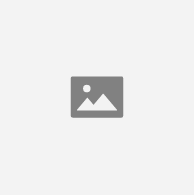

In [16]:
from hana_ml.visualizers.time_series_report import TimeSeriesReport, DatasetAnalysis
from hana_ml.visualizers.report_builder import Page, RemoteImageItem, LocalImageItem, DescriptionItem, ChartItem, TableItem
from hana_ml.algorithms.pal.tsa.changepoint import BCPD

report = TimeSeriesReport('test')
dataset_analysis = DatasetAnalysis(data=df_acf, endog="Y", key="ID")

pages = []

page0 = Page('Stationarity')
page0.addItem(dataset_analysis.stationarity_item())
pages.append(page0)

page1 = Page('Partial Autocorrelation')
page1.addItem(dataset_analysis.pacf_item())
pages.append(page1)

page2 = Page('Rolling Mean and Standard Deviation')
page2.addItems([dataset_analysis.moving_average_item(-3), dataset_analysis.rolling_stddev_item(10)])
pages.append(page2)

page3 = Page('Real and Seasonal')
page3.addItem(dataset_analysis.real_item())
page3.addItem(dataset_analysis.seasonal_item())
page3.addItems(dataset_analysis.seasonal_decompose_items())
pages.append(page3)

page4 = Page('Box')
for cycle in ['YEAR', 'MONTH', 'QUARTER']:
    page4.addItem(dataset_analysis.timeseries_box_item(cycle))
pages.append(page4)

page5 = Page('Quarter')
page5.addItem(dataset_analysis.quarter_item())
pages.append(page5)

page6 = Page('Outlier')
page6.addItem(dataset_analysis.outlier_item())
pages.append(page6)

page7 = Page('Change Points')
bcpd = BCPD(max_tcp=2, max_scp=1, max_harmonic_order =10, random_seed=1, max_iter=10000)
page7.addItem(dataset_analysis.change_points_item(bcpd))
pages.append(page7)

report.addPages(pages)

report.build()
report.generate_notebook_iframe(iframe_height=800)

#### Enhanced unified report

In [17]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal.unified_regression import UnifiedRegression
import numpy as np
import matplotlib.pyplot as plt
import logging
from hana_ml.algorithms.pal.utility import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_set, training_set, validation_set, test_set = DataSets.load_boston_housing_data(connection_context)

Table BOSTON_HOUSING_PRICES exists.


In [18]:
#PAL model visualizer doesn't support RDT's JSON fomat
model = UnifiedRegression(func='hybridgradientboostingtree')
model.fit(training_set, key="ID", label="MEDV")

In [19]:
from hana_ml.visualizers.unified_report import UnifiedReport

ur = UnifiedReport(model)
ur.set_model_report_style('v1')

In [20]:
ur.tree_debrief(digraph=False)

#### Model report with scoring tab

In [21]:
model.score(data=training_set, key="ID", label="MEDV")

(<hana_ml.dataframe.DataFrame at 0x1d0d78433a0>,
 <hana_ml.dataframe.DataFrame at 0x1d0d8a755b0>)

In [22]:
ur.build().display()

In order to review the unified regression model report better, you need to adjust the size of the left area or hide the left area temporarily!


#### Enhanced model storage with export_model/import_model

In [23]:
from hana_ml.model_storage import ModelStorage

ms = ModelStorage(connection_context)

In [24]:

model.name = "HGBT with Report"
model.version = 2
ur.build()
ms.save_model(model, save_report=True, force=True)

In [25]:
ms.export_model(name="HGBT with Report", version=2)

Models has been exported to C:\Users\I308290\hanamlapi\nutest\testscripts\pal\notebooks\HGBT with Report_2.


In [26]:
ms.import_model("C:\\Users\\I308290\\hanamlapi\\nutest\\testscripts\\pal\\notebooks\\HGBT with Report_2",
                force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


In [27]:
hgbt = ms.load_model("HGBT with Report", version=2)

In [28]:
hgbt.predict(test_set.deselect("MEDV"), key="ID").head(10).collect()

ID      SCORE LOWER_BOUND UPPER_BOUND  \
0  343  21.828168        None        None   
1  345  31.361832        None        None   
2  173  19.216107        None        None   
3  351  23.354556        None        None   
4  177  21.083385        None        None   
5  354  31.353054        None        None   
6  186  23.728565        None        None   
7  362  20.585150        None        None   
8   18  16.950618        None        None   
9  369  26.603576        None        None   

                                              REASON  
0  [{"attr":"LSTAT","val":2.0891777790633596,"pct...  
1  [{"attr":"LSTAT","val":8.025384502829521,"pct"...  
2  [{"attr":"RM","val":-2.439412672143974,"pct":3...  
3  [{"attr":"LSTAT","val":4.227277006251679,"pct"...  
4  [{"attr":"RM","val":-2.1047451123401057,"pct":...  
5  [{"attr":"LSTAT","val":8.709638593166181,"pct"...  
6  [{"attr":"TAX","val":1.4904163235889164,"pct":...  
7  [{"attr":"LSTAT","val":0.6379363393565236,"pct...  
8  [{"attr":"PTRATIO","val":-1.6087860990004362,"...  
9  [{"attr":"LSTAT","val":8.533072855145227,"pct"...

#### Export model in mlflow autologging

In [29]:
import mlflow
#mlflow.create_experiment("MY_Exp")
mlflow.set_experiment('MY_Exp')
model = UnifiedRegression(func='RandomForest')
with mlflow.start_run() as run:
    model.enable_mlflow_autologging(is_exported=True)
    model.fit(training_set, key="ID", label="MEDV")
    runid = run.info.run_id

In [30]:
print(model.mlflow_model_info)

{'run_id': '8c5c790715ba4e56ad470bb3302497a2', 'artifact_path': 'model', 'utc_time_created': '2023-01-16 03:10:18.718920', 'flavors': {'python_function': {'loader_module': 'hana_ml.model_storage.ModelStorage.load_mlflow_model', 'python_version': '3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]'}, 'hana_ml': {'model_storage': {'is_exported': True, 'name': 'UnifiedRegression4dd71897954b11edac60f47b099f40d8', 'version': 1}, 'hana_ml_version': '2.16.23031600'}}, '_signature': inputs: 
  ['ID': integer, 'CRIM': double, 'ZN': double, 'INDUS': double, 'CHAS': integer, 'NOX': double, 'RM': double, 'AGE': double, 'DIS': double, 'RAD': integer, 'TAX': integer, 'PTRATIO': double, 'BLACK': double, 'LSTAT': double]
outputs: 
  ['MEDV': double]
, '_saved_input_example_info': None, 'model_uuid': '8961d58d366947d089bd0e8688aa5ca0'}


In [31]:
from hana_ml.model_storage import ModelStorage
mymodel = ModelStorage.load_mlflow_model(connection_context=connection_context, model_uri='runs:/{}/model'.format(runid))
mymodel.predict(test_set.deselect("MEDV"), key="ID").head(10).collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


ID    SCORE LOWER_BOUND  UPPER_BOUND  \
0  343  24.6807        None     3.698482   
1  345  30.6313        None     4.432784   
2  173  20.6701        None     2.915102   
3  351  24.1351        None     2.547738   
4  177  21.9435        None     1.841552   
5  354  32.1483        None     6.722012   
6  186  24.1298        None     4.508357   
7  362  19.4134        None     1.971832   
8   18  19.2866        None     1.857739   
9  369  22.3167        None     8.604617   

                                              REASON  
0  [{"attr":"RM","pct":26.0,"val":-65.77681060000...  
1  [{"attr":"RM","pct":27.0,"val":-68.87020333666...  
2  [{"attr":"RM","pct":25.0,"val":-65.07840916666...  
3  [{"attr":"RM","pct":25.0,"val":-65.30624134999...  
4  [{"attr":"RM","pct":25.0,"val":-63.94359799999...  
5  [{"attr":"RM","pct":26.0,"val":-66.20452434999...  
6  [{"attr":"RM","pct":25.0,"val":-63.46227683333...  
7  [{"attr":"LSTAT","pct":24.0,"val":-61.82953880...  
8  [{"attr":"LSTAT","pct":24.0,"val":-63.80122876...  
9  [{"attr":"RM","pct":23.0,"val":-58.70461709999...

#### Early_stop in hgbt

In [32]:
from hana_ml.algorithms.pal.trees import HybridGradientBoostingClassifier
cv_range = []
cv_range.append(('learning_rate',[0.1, 1.0, 3]))
cv_range.append(('n_estimators', [4, 10, 3]))
cv_range.append(('split_threshold', [0.1, 1.0, 3]))
hgc = HybridGradientBoostingClassifier(n_estimators=4, split_threshold=0,
                                       learning_rate=0.5, fold_num=5, max_depth=6,
                                       resampling_method='cv', cross_validation_range=cv_range,
                                       evaluation_metric='error_rate', tolerant_iter_num=3, validation_set_rate=0.2)
hgc.fit(diabetes_train, key= 'ID', label='CLASS', categorical_variable=['CLASS'])

####  successive halving/hyperband in FRM and ALS

In [33]:
data_list = [
                (1, 'A', 'Movie1', 4.8),(2, 'A', 'Movie2', 4.0),(3, 'A', 'Movie4', 4.0),(4, 'A', 'Movie5', 4.0),
                (5,'A', 'Movie6', 4.8),(6,'A', 'Movie8', 3.8),(7,'A', 'Bad_Movie', 2.5),(8,'B', 'Movie2', 4.8),
                (9,'B', 'Movie3', 4.8),(10,'B', 'Movie4', 5.0),(11,'B', 'Movie5', 5.0),(12,'B', 'Movie7', 3.5),
                (13,'B', 'Movie8', 4.8),(14,'B', 'Bad_Movie', 2.8),(15,'C', 'Movie1', 4.1),(16,'C', 'Movie2', 4.2),
                (17,'C', 'Movie4', 4.2),(18,'C', 'Movie5', 4.0),(19,'C', 'Movie6', 4.2),(20,'C', 'Movie7', 3.2),
                (21,'C', 'Movie8', 3.0),(22,'C', 'Bad_Movie', 2.5),(23,'D', 'Movie1', 4.5),(24,'D', 'Movie3', 3.5),
                (25,'D', 'Movie4', 4.5),(26,'D', 'Movie6', 3.9),(27,'D', 'Movie7', 3.5),(28,'D', 'Movie8', 3.5),
                (29,'D', 'Bad_Movie', 2.5),(30,'E', 'Movie1', 4.5),(31,'E', 'Movie2', 4.0),(32,'E', 'Movie3', 3.5),
                (33,'E', 'Movie4', 4.5),(34,'E', 'Movie5', 4.5),(35,'E', 'Movie6', 4.2),(36,'E', 'Movie7', 3.5),
                (37,'E', 'Movie8', 3.5)
            ]

shals_df = dataframe.create_dataframe_from_pandas(connection_context, pandas_df=pd.DataFrame(data_list, columns=["ID", "USER", "MOVIE", "RATING"]),
                                                  table_name="#SH_ALS", force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


In [34]:
from hana_ml.algorithms.pal.recommender import ALS

als = ALS(implicit=True, resampling_method='cv_sha',
          search_strategy='grid', evaluation_metric='rmse',
          fold_num=5, repeat_times=2, timeout=0,
          progress_indicator_id='PAL_ALS',
          param_range=[('factor_num',[1,1,5])],
          param_values=[('lamb',[1e-1,1e-2,1e-3]),('alpha',[1.,2.])],
          max_iter=40, tol=1e-6,
          exit_interval=5, linear_solver='choleskey',
          thread_ratio=-1, random_state=2022)

als.fit(shals_df, key='ID')

#### pipeline and auto-ml module with predefined output tabels

In [36]:
my_pipeline = Pipeline([
                    ('PCA', PCA(scaling=True, scores=True)),
                    ('HGBT_Classifier', HybridGradientBoostingClassifier(
                                            n_estimators=4, split_threshold=0,
                                            learning_rate=0.5, fold_num=5,
                                            max_depth=6))])
connection_context.drop_table("MY_MODEL_TBL")
my_pipeline.fit(data=diabetes_train, key="ID", label="CLASS", model_table_name="MY_MODEL_TBL")



ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: MY_MODEL_TBL: line 1 col 23 (at pos 22)')


In [37]:
my_pipeline.model_.select_statement

'SELECT * FROM "MY_MODEL_TBL"'